# Classifying Stars

## Background

<p>This program creates an <strong>SVM model</strong> for classifying stars as pulsar or not pulsar.</p>
<p>Pulsar stars have strong gravitational fields. Astronomers use them to test theories of gravity.</p>
<p>There are over 1000 known pulsar stars. Each one has a unique pulse profile. A pulse profile is the measure of a pulsar's brightness as it rotates.
<p>The DM-SNR curve tells us how clear a signal is and if it's coming from Earth or a star.</p>

## Finding

The best model in this program is __Tuned Model 1__. It uses the __kurtosis_profile and mean_profile__ features to predict the target class, and it has the highest true positives score of __79.6%__.

## Load Data

In [94]:
# load library packaqes and data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

%matplotlib inline

columns = ['mean_profile', 'stdev_profile', 'kurtosis_profile', 'skewness_profile', \
           'mean_curve', 'stdev_curve', 'kurtosis_curve', 'skewness_curve', 'target']

stars_df = pd.read_csv('pulsar_stars.csv', 
                       header = 0, 
                       names = columns)
# stars = pd.read_csv('pulsar_stars.csv')

## Explore Data

#### The dataset contains __17,898__ entries and __no null values__.

In [95]:
# review the dataset
stars_df

,mean_profile,stdev_profile,kurtosis_profile,skewness_profile,mean_curve,stdev_curve,kurtosis_curve,skewness_curve,target
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0
...,...,...,...,...,...,...,...,...,...
17893,136.429688,59.847421,-0.187846,-0.738123,1.296823,12.166062,15.450260,285.931022,0
17894,122.554688,49.485605,0.127978,0.323061,16.409699,44.626893,2.945244,8.297092,0
17895,119.335938,59.935939,0.159363,-0.743025,21.430602,58.872000,2.499517,4.595173,0
17896,114.507812,53.902400,0.201161,-0.024789,1.946488,13.381731,10.007967,134.238910,0


In [96]:
# check for nulls and review dtypes
stars_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17898 entries, 0 to 17897
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   mean_profile      17898 non-null  float64
 1   stdev_profile     17898 non-null  float64
 2   kurtosis_profile  17898 non-null  float64
 3   skewness_profile  17898 non-null  float64
 4   mean_curve        17898 non-null  float64
 5   stdev_curve       17898 non-null  float64
 6   kurtosis_curve    17898 non-null  float64
 7   skewness_curve    17898 non-null  float64
 8   target            17898 non-null  int64  
dtypes: float64(8), int64(1)
memory usage: 1.2 MB


#### There are __1,639 pulsar stars__ in the dataset.

In [97]:
stars_df['target'].value_counts()

0    16259
1     1639
Name: target, dtype: int64

#### Means and standard deviations __vary__ across features, so the dataset should be normalized before training.

In [98]:
# review metrics
stars_df.describe().round(2)

,mean_profile,stdev_profile,kurtosis_profile,skewness_profile,mean_curve,stdev_curve,kurtosis_curve,skewness_curve,target
count,17898.00,17898.00,17898.00,17898.00,17898.00,17898.00,17898.00,17898.00,17898.00
mean,111.08,46.55,0.48,1.77,12.61,26.33,8.30,104.86,0.09
std,25.65,6.84,1.06,6.17,29.47,19.47,4.51,106.51,0.29
min,5.81,24.77,-1.88,-1.79,0.21,7.37,-3.14,-1.98,0.00
25%,100.93,42.38,0.03,-0.19,1.92,14.44,5.78,34.96,0.00
50%,115.08,46.95,0.22,0.20,2.80,18.46,8.43,83.06,0.00
75%,127.09,51.02,0.47,0.93,5.46,28.43,10.70,139.31,0.00
max,192.62,98.78,8.07,68.10,223.39,110.64,34.54,1191.00,1.00


## Find Predictor Variables

#### The __top 3 predictors__ are:
<ol>
<li>kurtosis_profile</li>
<li>skewness_profile</li>
<li>mean_profile</li>
</ol>

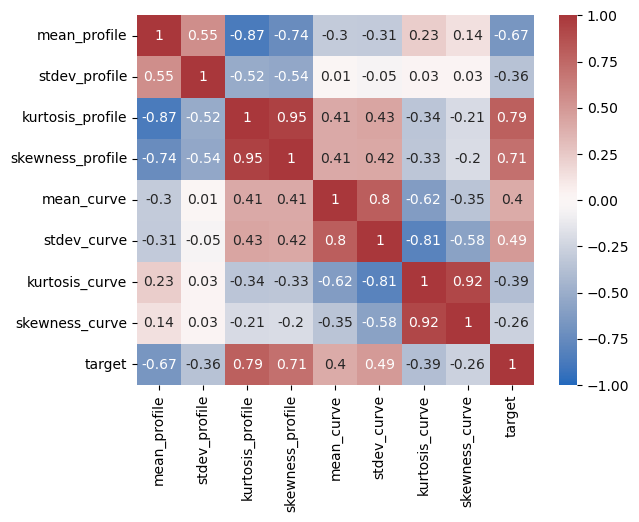

In [99]:
# identify the top three predictor variables
sns.heatmap(stars_df.corr().round(2), 
            annot=True, 
            vmin = -1, 
            vmax = 1, 
            center = 0, 
            cmap= 'vlag') 
plt.show()

In [100]:
print('Feature:', list(stars_df.corr().abs().nlargest(4, 'target').index))
print('Corr:', list(stars_df.corr().abs().nlargest(4, 'target').values[:, 8].round(2)))

Feature: ['target', 'kurtosis_profile', 'skewness_profile', 'mean_profile']
Corr: [1.0, 0.79, 0.71, 0.67]


#### Separations between `target` values can be seen in these two plots:
<ul>
    <li>mean_profile vs kurtosis_profile</li>
    <li>mean_profile vs skewness_profile</li>
</ul>

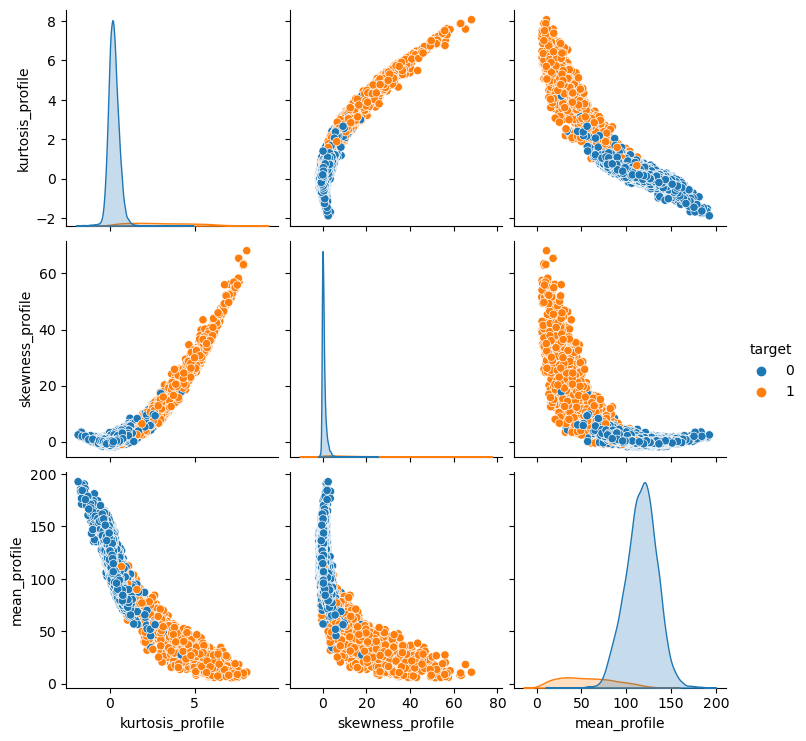

In [101]:
# visualize combinations of the three predictors
sns.pairplot(stars_df, hue = 'target', vars = ['kurtosis_profile', 'skewness_profile','mean_profile'] )
plt.show()

## Select Model 1 Data

#### Model 1 Predictors:
<ol>
    <li>kurtosis_profile</li>
    <li>mean_profile</li>
</ol>

#### Model 1 Target:
<ul>
    <li>target</li>
</ul>

In [102]:
# split dataset into feature and target variables
feature_columns = ['kurtosis_profile', 'mean_profile']
target_columns = 'target'
X = stars_df[feature_columns]
y = stars_df[target_columns]
print(X.head())
print(y.head())

   kurtosis_profile  mean_profile
0         -0.234571    140.562500
1          0.465318    102.507812
2          0.323328    103.015625
3         -0.068415    136.750000
4          0.600866     88.726562
0    0
1    0
2    0
3    0
4    0
Name: target, dtype: int64


In [103]:
# normalize feature variables (scale between 0 and 1)
X_min = X.min()
X_max = X.max()
X_range = (X_max - X_min)
X = (X - X_min) / (X_range)

X.head()

,kurtosis_profile,mean_profile
0,0.165043,0.721342
1,0.235415,0.517628
2,0.221138,0.520346
3,0.181750,0.700933
4,0.249044,0.443854


## Split Model 1 Data

#### The split created  __13,423 training__ entries and __4,475 testing__ entries.

In [104]:
# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 129)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(13423, 2) (13423,)
(4475, 2) (4475,)


## Initialize Model 1

In [105]:
# initialize model
svc_model_1 = SVC()

## Train Model 1

In [106]:
# fit model to training data
svc_model_1.fit(X_train, y_train)

SVC()

## Test Model 1

In [107]:
# run prediction on test data
y_predict = svc_model_1.predict(X_test)

## Grade Model 1

#### Model 1's accuracy score is __98%__, but this is misleading.

In [108]:
# accuracy score
accuracy_score(y_test, y_predict).round(2)

0.98

#### The original dataset had a __10:1 bias__ favoring non-pulsars. This means models will err towards classifying data as non-pulsar. 

#### Model 1's sensitivity scores:
<ul>
    <li>True Positives: <strong>79.4%</strong>. Tuning the model could improve this score.</li>
    <li>True Negatives: <strong>99.7%</strong>.</li>
</ul>

In [109]:
# confusion matrix
cm = np.array(confusion_matrix(y_test, y_predict, labels=[1,0]))
confusion = pd.DataFrame(cm, index=['is_pulsar', 'is_not'],
                         columns=['predicted_pulsar','predicted_not'])
confusion

,predicted_pulsar,predicted_not
is_pulsar,331,86
is_not,14,4044


In [110]:
# calculate true positives and negatives
true_positives = 331 / (331 + 86)
true_negatives = 4044 / (14 + 4044)
print('True Positives:', true_positives)
print('True Negatives:', true_negatives)

True Positives: 0.7937649880095923
True Negatives: 0.9965500246426812


In [111]:
# classification report
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      4058
           1       0.96      0.79      0.87       417

    accuracy                           0.98      4475
   macro avg       0.97      0.90      0.93      4475
weighted avg       0.98      0.98      0.98      4475



## Plot Model 1

-0.1
1.1
-0.1
1.1
0.011
(12100, 2)


/Users/Gina/anaconda3/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


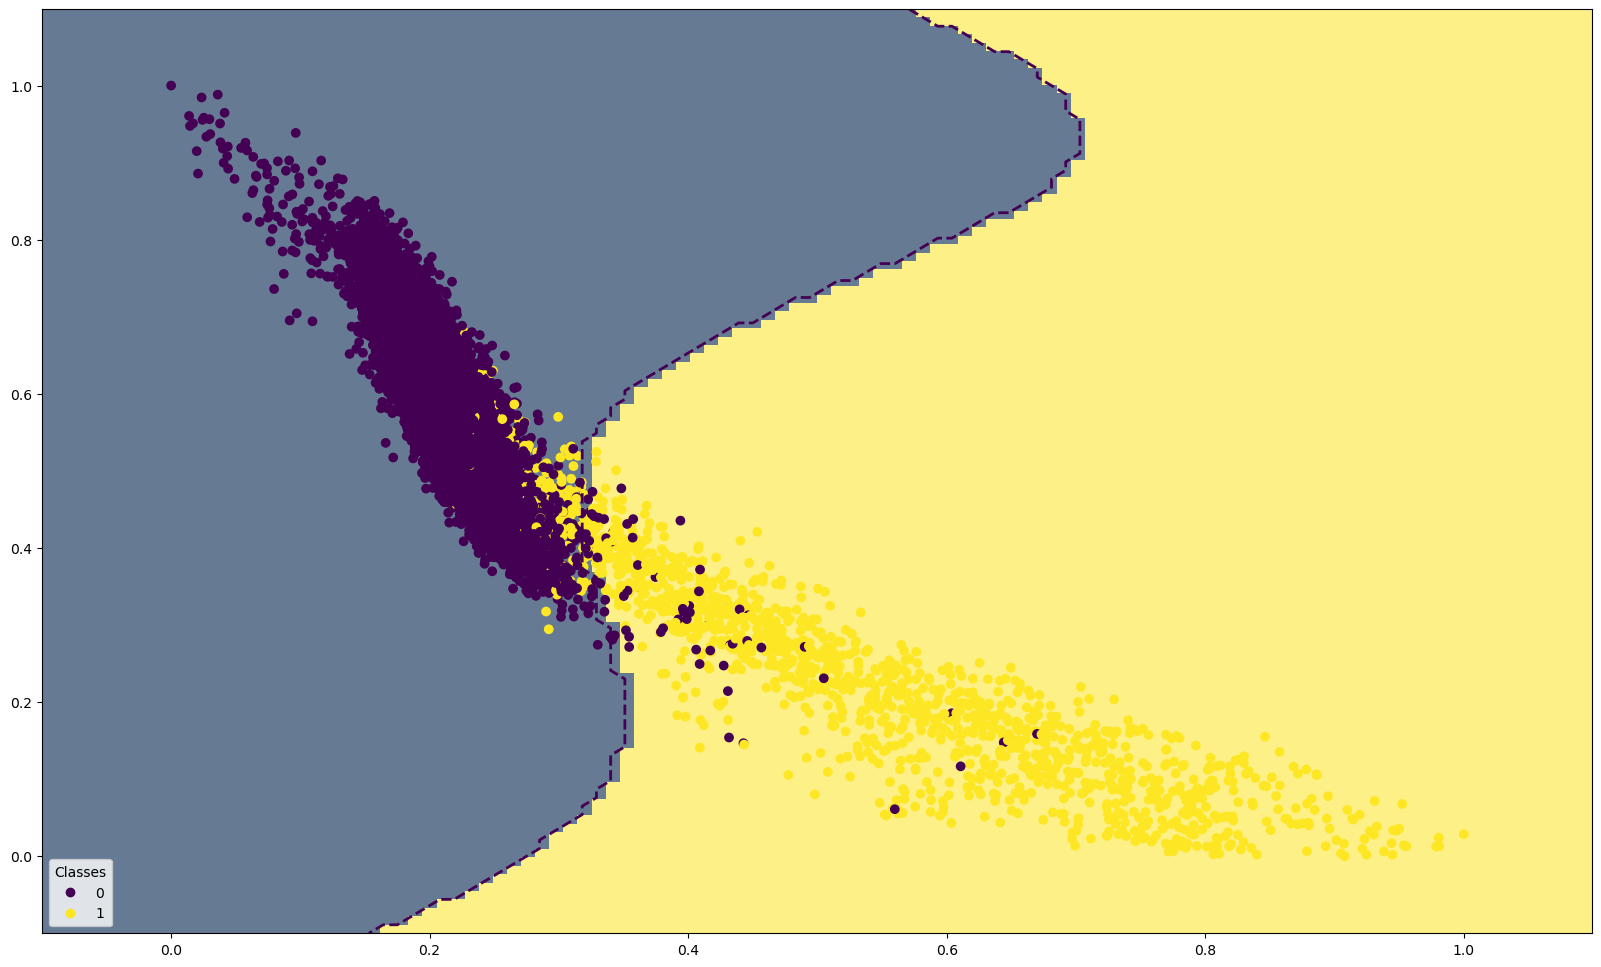

In [112]:
# plot the SVM classification
plt.figure(figsize = (20,12))
scatter = plt.scatter(X['kurtosis_profile'], X['mean_profile'], c = y)   # c is color, and y is the target

x_min, x_max = X['kurtosis_profile'].min() - .1, X['kurtosis_profile'].max() + .1
print(x_min)
print(x_max)
y_min, y_max = X['mean_profile'].min() - .1, X['mean_profile'].max() + .1
print(y_min)
print(y_max)
h = abs((x_max/x_min)/1000)
print(h)

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# make predictions using model
r = np.c_[xx.ravel(), yy.ravel()]
print(r.shape)
z = svc_model_1.predict(np.c_[xx.ravel(), yy.ravel()])
z = z.reshape(xx.shape)

plt.imshow(
    z,
    interpolation="nearest",   # nearest = nearest neighbor
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    aspect="auto",
    origin="lower",
    cmap='cividis',   # for color blindness
    alpha = 0.6
)

contours = plt.contour(xx, yy, z, levels=[0], linewidths=2, linestyles="dashed")

plt.legend(*scatter.legend_elements(), loc="lower left", title="Classes")
plt.show()

## Tune Model 1

In [113]:
# change the hyperperameters
svc_model_1 = SVC(kernel='linear', C=100)

## Re-Train Model 1

In [114]:
# fit tuned model to training data
svc_model_1.fit(X_train, y_train)

SVC(C=100, kernel='linear')

## Re-Test Model 1

In [115]:
# run prediction on test data
y_predict = svc_model_1.predict(X_test)

## Grade Tuned Model 1

#### The accuracy score of __98%__ did not change.
#### The true positives score barely increased from 79.4% to __79.6%__. 
#### The true negatives score of __99.7%__ did not change.

In [116]:
# accuracy score
accuracy_score(y_test, y_predict).round(2)

0.98

In [117]:
# confusion matrix
cm = np.array(confusion_matrix(y_test, y_predict, labels=[1,0]))
confusion = pd.DataFrame(cm, index=['is_pulsar', 'is_not'],
                         columns=['predicted_pulsar','predicted_not'])
confusion

,predicted_pulsar,predicted_not
is_pulsar,332,85
is_not,11,4047


In [118]:
# calculate true positives and negatives
true_positives = 332 / (332 + 85)
true_negatives = 4047 / (11 + 4047)
print('True Positives:', true_positives)
print('True Negatives:', true_negatives)

True Positives: 0.7961630695443646
True Negatives: 0.9972893050763924


In [119]:
# classification report
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      4058
           1       0.97      0.80      0.87       417

    accuracy                           0.98      4475
   macro avg       0.97      0.90      0.93      4475
weighted avg       0.98      0.98      0.98      4475



## Plot Tuned Model 1

-0.1
1.1
-0.1
1.1
0.011
(12100, 2)


/Users/Gina/anaconda3/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


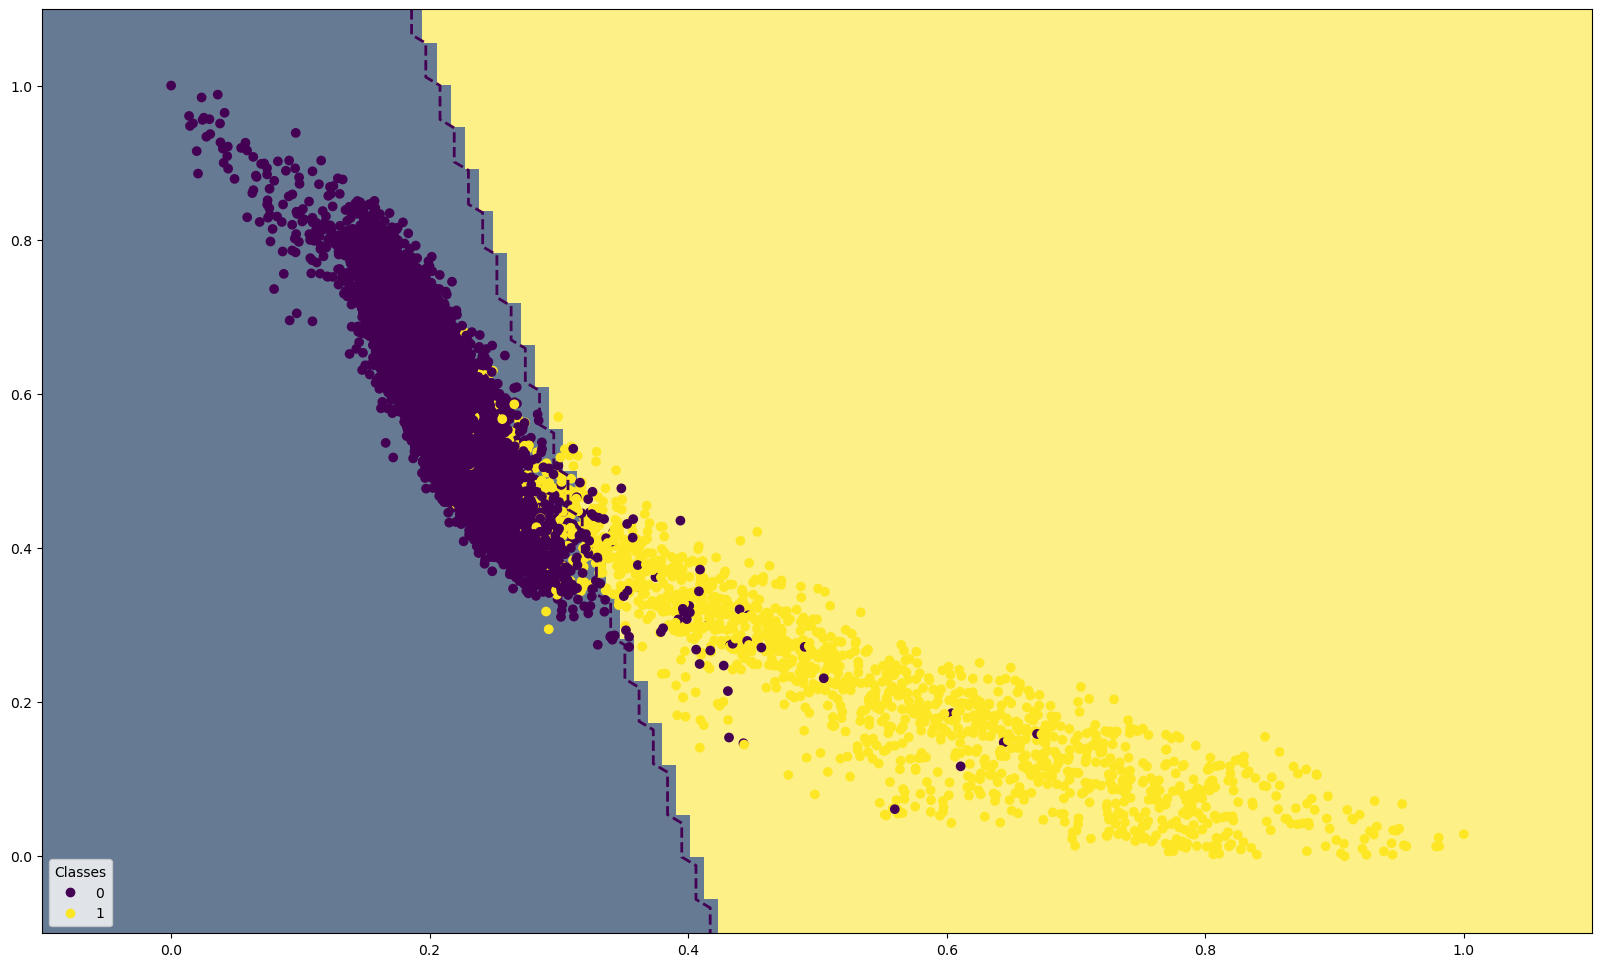

In [120]:
# plot the SVM classification
plt.figure(figsize = (20,12))
scatter = plt.scatter(X['kurtosis_profile'], X['mean_profile'], c = y)   # c is color, and y is the target

x_min, x_max = X['kurtosis_profile'].min() - .1, X['kurtosis_profile'].max() + .1
print(x_min)
print(x_max)
y_min, y_max = X['mean_profile'].min() - .1, X['mean_profile'].max() + .1
print(y_min)
print(y_max)
h = abs((x_max/x_min)/1000)
print(h)

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# make predictions using model
r = np.c_[xx.ravel(), yy.ravel()]
print(r.shape)
z = svc_model_1.predict(np.c_[xx.ravel(), yy.ravel()])
z = z.reshape(xx.shape)

plt.imshow(
    z,
    interpolation="nearest",   # nearest = nearest neighbor
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    aspect="auto",
    origin="lower",
    cmap='cividis',   # for color blindness
    alpha = 0.6
)

contours = plt.contour(xx, yy, z, levels=[0], linewidths=2, linestyles="dashed")

plt.legend(*scatter.legend_elements(), loc="lower left", title="Classes")
plt.show()

## Cross Validate Tuned Model 1

#### On average, tuned model 1 is __97%__ accurate and has a low __standard deviation of 0.004__.

In [148]:
# run cross validation
cv_results = cross_val_score(estimator=svc_model_1, X=X_train, y=y_train)   # uses default cv and scoring

In [149]:
# display results
print('Scores:', list((cv_results.round(2))))
print('The mean: {}'.format(cv_results.mean().round(2)))
print('The standard deviation: {}'.format(cv_results.std().round(3))) 

Scores: [0.97, 0.96, 0.97, 0.97, 0.97]
The mean: 0.97
The standard deviation: 0.004


## Select Model 2 Data

#### Model 2 Predictors:
<ol>
    <li>skewness_profile</li>
    <li>mean_profile</li>
</ol>

#### Model 2 Target:
<ul>
    <li>target</li>
</ul>

In [121]:
# split dataset into feature and target variables
feature_columns = ['skewness_profile', 'mean_profile']
target_columns = 'target'
X = stars_df[feature_columns]
y = stars_df[target_columns]
print(X.head())
print(y.head())

   skewness_profile  mean_profile
0         -0.699648    140.562500
1         -0.515088    102.507812
2          1.051164    103.015625
3         -0.636238    136.750000
4          1.123492     88.726562
0    0
1    0
2    0
3    0
4    0
Name: target, dtype: int64


In [122]:
# normalize feature variables (scale between 0 and 1)
X_min = X.min()
X_max = X.max()
X_range = (X_max - X_min)
X = (X - X_min) / (X_range)

X.head()

,skewness_profile,mean_profile
0,0.015627,0.721342
1,0.018268,0.517628
2,0.040677,0.520346
3,0.016534,0.700933
4,0.041712,0.443854


## Split Model 2 Data

#### The split created  __13,423 training__ entries and __4,475 testing__ entries.

In [123]:
# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 129)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(13423, 2) (13423,)
(4475, 2) (4475,)


## Initialize Model 2

In [124]:
# initialize model
svc_model_2 = SVC()

## Train Model 2

In [125]:
# fit model to training data
svc_model_2.fit(X_train, y_train)

SVC()

## Test Model 2

In [126]:
# run prediction on test data
y_predict = svc_model_2.predict(X_test)

## Grade Model 2

#### Model 2's accuracy score is __97%__.

#### Model 2's sensitivity scores:
<ul>
    <li>True Positives: <strong>70.3%</strong>. This is worse than model 1's scores. Tuning the model could improve this score.</li>
    <li>True Negatives: <strong>99.8%</strong>.</li>
</ul>

In [127]:
# accuracy score
accuracy_score(y_test, y_predict).round(2)

0.97

In [128]:
# confusion matrix
cm = np.array(confusion_matrix(y_test, y_predict, labels=[1,0]))
confusion = pd.DataFrame(cm, index=['is_pulsar', 'is_not'],
                         columns=['predicted_pulsar','predicted_not'])
confusion

,predicted_pulsar,predicted_not
is_pulsar,293,124
is_not,8,4050


In [129]:
# calculate true positives and negatives
true_positives = 293 / (293 + 124)
true_negatives = 4050 / (8 + 4050)
print('True Positives:', true_positives)
print('True Negatives:', true_negatives)

True Positives: 0.7026378896882494
True Negatives: 0.9980285855101035


In [130]:
# classification report
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      4058
           1       0.97      0.70      0.82       417

    accuracy                           0.97      4475
   macro avg       0.97      0.85      0.90      4475
weighted avg       0.97      0.97      0.97      4475



## Plot Model 2

-0.1
1.1
-0.1
1.1
0.011
(12100, 2)


/Users/Gina/anaconda3/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


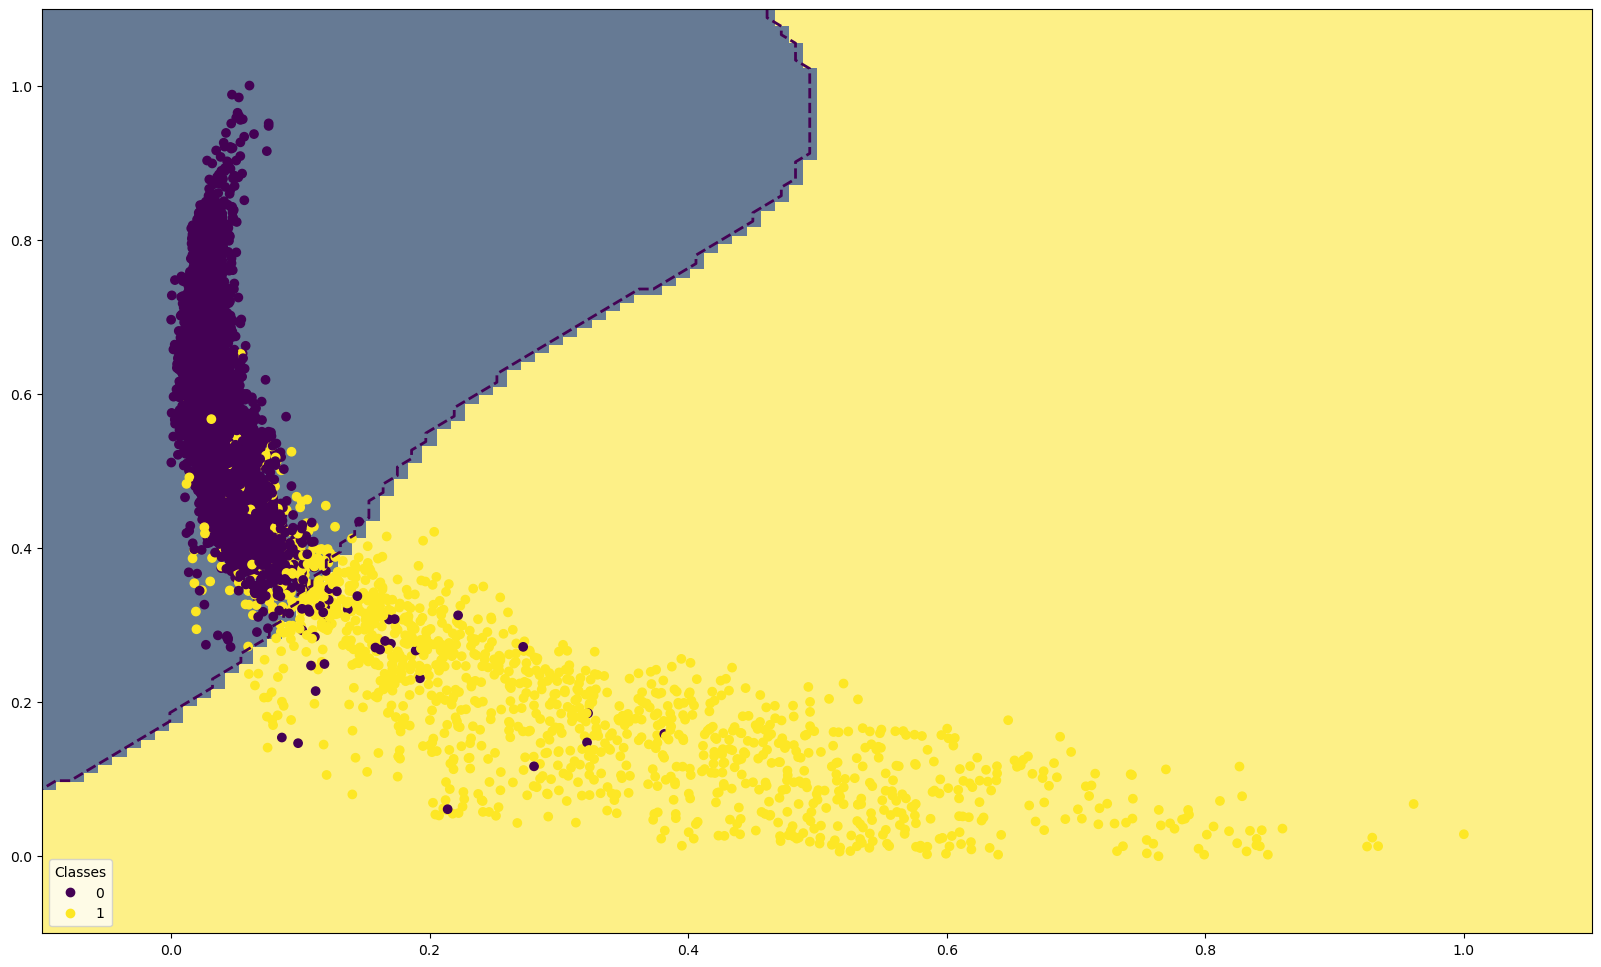

In [131]:
# plot the SVM classification
plt.figure(figsize = (20,12))
scatter = plt.scatter(X['skewness_profile'], X['mean_profile'], c = y)   # c is color, and y is the target

x_min, x_max = X['skewness_profile'].min() - .1, X['skewness_profile'].max() + .1
print(x_min)
print(x_max)
y_min, y_max = X['mean_profile'].min() - .1, X['mean_profile'].max() + .1
print(y_min)
print(y_max)
h = abs((x_max/x_min)/1000)
print(h)

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# make predictions using model
r = np.c_[xx.ravel(), yy.ravel()]
print(r.shape)
z = svc_model_2.predict(np.c_[xx.ravel(), yy.ravel()])
z = z.reshape(xx.shape)

plt.imshow(
    z,
    interpolation="nearest",   # nearest = nearest neighbor
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    aspect="auto",
    origin="lower",
    cmap='cividis',   # for color blindness
    alpha = 0.6
)

contours = plt.contour(xx, yy, z, levels=[0], linewidths=2, linestyles="dashed")

plt.legend(*scatter.legend_elements(), loc="lower left", title="Classes")
plt.show()

## Tune Model 2

In [132]:
# initialize model
svc_model_2 = SVC()

## Grid Search for Model 2

#### A grid search will automate the tuning process.

#### FYI: This grid search takes about 30 minutes to run. Results are commented in the cell.

In [137]:
# run a grid search
param_grid = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
              'C': [.01, .1, .5, 1, 5, 10, 50, 100, 500, 1000, 5000],
              'gamma': ['auto', 0, 0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(svc_model_2, param_grid)

%time grid.fit(X_train, y_train)

print(grid.best_params_)

# Results:
#    CPU times: user 23min 10s, sys: 1min 52s, total: 25min 2s
#    Wall time: 30min 36s
#    {'C': 5000, 'gamma': 'auto', 'kernel': 'rbf'}

CPU times: user 23min 10s, sys: 1min 52s, total: 25min 2s
Wall time: 30min 36s
{'C': 5000, 'gamma': 'auto', 'kernel': 'rbf'}


In [138]:
print(grid.best_params_)

# Results:
#    {'C': 5000, 'gamma': 'auto', 'kernel': 'rbf'}

{'C': 5000, 'gamma': 'auto', 'kernel': 'rbf'}


In [139]:
# change the hyperperameters
svc_model_2 = SVC(C=5000, gamma='auto', kernel='rbf')

## Re-Train Model 2

In [140]:
# fit tuned model to training data
svc_model_2.fit(X_train, y_train)

SVC(C=5000, gamma='auto')

## Re-Test Model 2

In [141]:
# run prediction on test data
y_predict = svc_model_2.predict(X_test)

## Grade Tuned Model 2

#### Using a grid search was __not worthwhile__.
#### The grid search based its decision on accuracy scores. However, in this case, it's better to use the true positives score.

#### The accuracy score of __97%__ did not change.
#### The true positives score slightly decreased from 70.3% to __69.3%__.
#### The true negatives score of __99.8%__ did not change.

In [142]:
# accuracy score
accuracy_score(y_test, y_predict).round(2)

0.97

In [143]:
# confusion matrix
cm = np.array(confusion_matrix(y_test, y_predict, labels=[1,0]))
confusion = pd.DataFrame(cm, index=['is_pulsar', 'is_not'],
                         columns=['predicted_pulsar','predicted_not'])
confusion

,predicted_pulsar,predicted_not
is_pulsar,289,128
is_not,8,4050


In [144]:
# calculate true positives and negatives
true_positives = 289 / (289 + 128)
true_negatives = 4050 / (8 + 4050)
print('True Positives:', true_positives)
print('True Negatives:', true_negatives)

True Positives: 0.6930455635491607
True Negatives: 0.9980285855101035


In [145]:
# classification report
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      4058
           1       0.97      0.69      0.81       417

    accuracy                           0.97      4475
   macro avg       0.97      0.85      0.90      4475
weighted avg       0.97      0.97      0.97      4475



## Plot Tuned Model 2

-0.1
1.1
-0.1
1.1
0.011
(12100, 2)


/Users/Gina/anaconda3/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


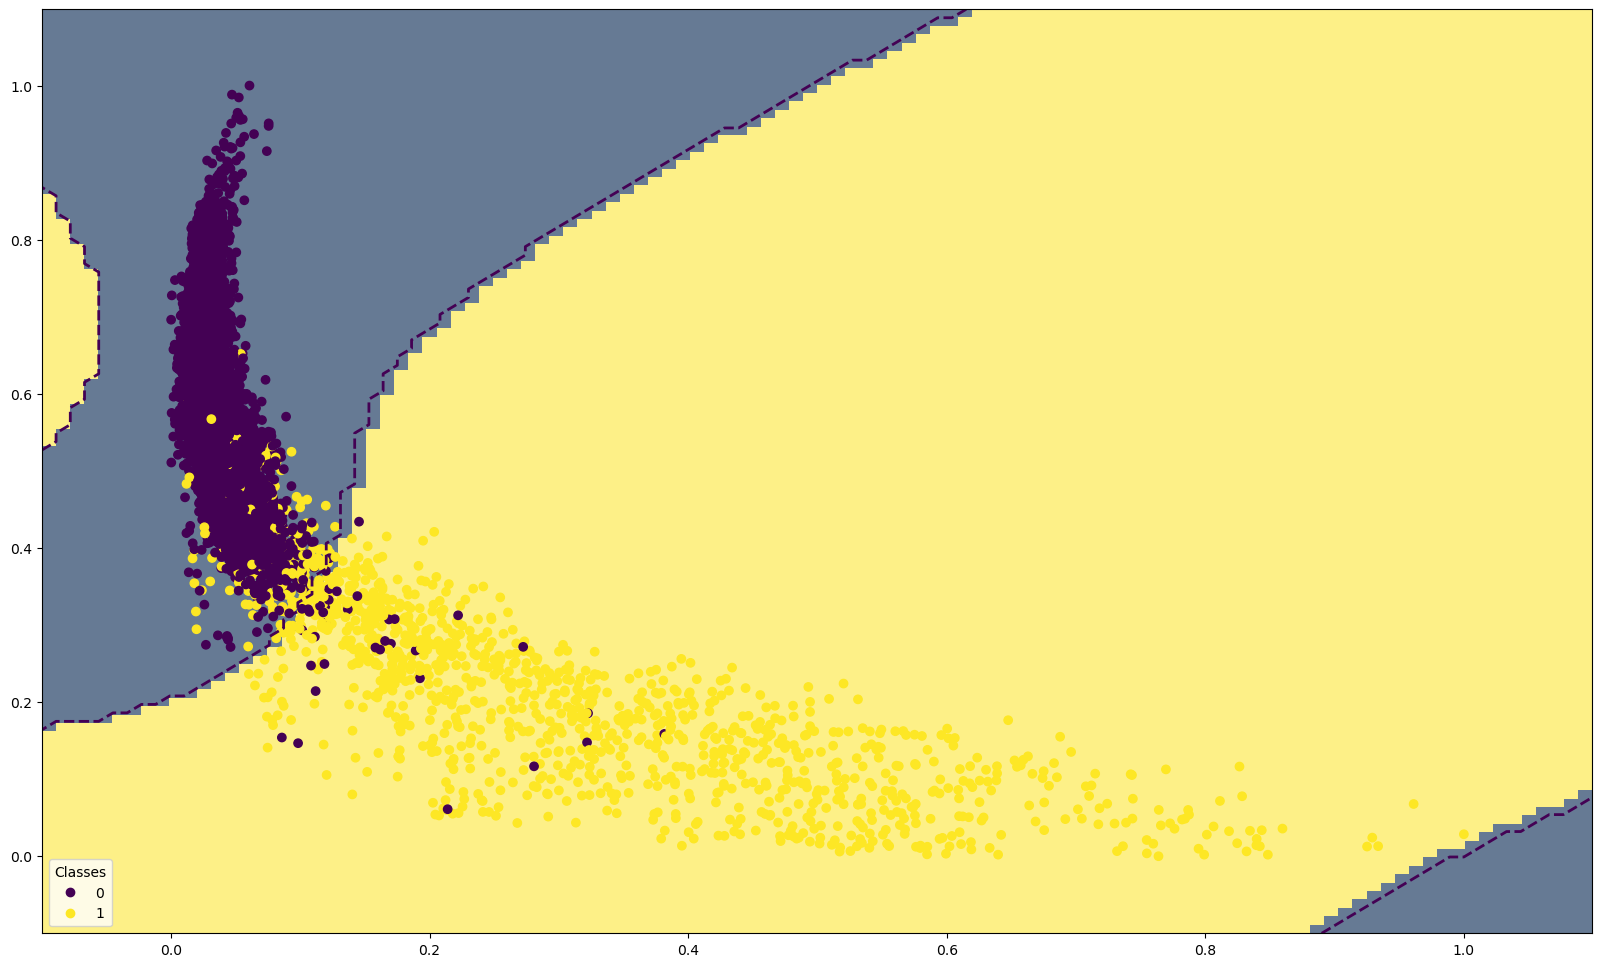

In [147]:
# plot the SVM classification
plt.figure(figsize = (20,12))
scatter = plt.scatter(X['skewness_profile'], X['mean_profile'], c = y)   # c is color, and y is the target

x_min, x_max = X['skewness_profile'].min() - .1, X['skewness_profile'].max() + .1
print(x_min)
print(x_max)
y_min, y_max = X['mean_profile'].min() - .1, X['mean_profile'].max() + .1
print(y_min)
print(y_max)
h = abs((x_max/x_min)/1000)
print(h)

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# make predictions using model
r = np.c_[xx.ravel(), yy.ravel()]
print(r.shape)
z = svc_model_2.predict(np.c_[xx.ravel(), yy.ravel()])
z = z.reshape(xx.shape)

plt.imshow(
    z,
    interpolation="nearest",   # nearest = nearest neighbor
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    aspect="auto",
    origin="lower",
    cmap='cividis',   # for color blindness
    alpha = 0.6
)

contours = plt.contour(xx, yy, z, levels=[0], linewidths=2, linestyles="dashed")

plt.legend(*scatter.legend_elements(), loc="lower left", title="Classes")
plt.show()

## Pulsar Star Resources

https://www.sciencedirect.com/topics/engineering/signal-to-noise-ratio#:~:text=Signal%2Dto%2Dnoise%20ratio%20(SNR)%20is%20a%20measure,power%2C%20often%20expressed%20in%20decibels.
"Signal-to-noise ratio (SNR or S/N) is a measure used in science and engineering that compares the level of a desired signal to the level of background noise." 

https://en.wikipedia.org/wiki/Signal-to-noise_ratio
"SNR is defined as the ratio of signal power to noise power, often expressed in decibels. 
A ratio higher than 1:1 (greater than 0 dB) indicates more signal than noise."

https://www.physics.mcgill.ca/~rlynch/Outreach/PSC_search_guide.pdf
"It is important to note where the DM curve is peaking when you are trying to determine if
your pulsar candidate is real. If the curve reaches its highest point at a DM of zero, then
the signal must not have traveled through any electrons to get to Earth. But that must
mean that the signal actually originated at the Earth, and since there are no pulsars on the
surface of our planet (a very good thing!) then we know that we must actually be looking
at RFI. For this reason, the DM of a signal is one of the best ways we have of distinguishing
between RFI and a true astronomical signal from space."

https://www.britannica.com/science/pulsar
"Because pulsars slow down so gradually, they are very accurate clocks. 
Since pulsars also have strong gravitational fields, this accuracy can be used to test theories of gravity."

https://heasarc.gsfc.nasa.gov/docs/objects/pulsars/pulsars_lc.html
"Among the more than 1000 known pulsars, these seven are seen by gamma-ray telescopes and in some cases at other wavelengths. The pulse shapes (sometimes called "light curves" by pulsar astronomers) show the brightness of each pulsar as the neutron star makes one complete rotation. Here the pulse shapes as seen by radio, optical, X-ray, and gamma-ray telescopes are shown. The variety of pulse shapes is quite large, both from pulsar to pulsar and for individual pulsars seen by different telescopes. The Crab pulsar (far left) looks much the same to all telescopes. The Geminga pulsar (second from right) is only seen clearly in X-rays and gamma rays. The Vela pulsar (third from left) has a different pulse shape at each wavelength, and the pulses do not even arrive at the same time (although they all repeat with the same period, determined by the time it takes the neutron star to rotate)."